In [ ]:
""" IN THE NAME OF  ALLAH , THE MOST GRACIOUS, THE MOST MERCIFUL. """

In [1]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import Tensor
from torch.utils.data import DataLoader, random_split

modules_path = 'C:/Users/PMLS/FYP/Modules/'
dataset_path = 'C:/Users/PMLS/FYP/Dataset/STMM'
save_path = "C:/Users/PMLS/FYP/Models"

sys.path.insert(1, modules_path)
from video_dataset import VideoFrameDataset, ImglistToTensor

if False and torch.xpu.is_available():
    device = torch.device("xpu")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

C:\Users\PMLS\anaconda3\Lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\PMLS\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


cpu


In [2]:
# Load dataset
#img_w = 640
#img_h = 480
#frames_per_video = 7
batch_size = 10
num_workers = 0

dataset = VideoFrameDataset(
    root_path= f"{dataset_path}",
    annotationfile_path=f"{dataset_path}/annotations.txt",
    num_segments=8,
    frames_per_segment=1,
    imagefile_template='{:01d}.jpg',
    transform=ImglistToTensor(),
    test_mode=False
)
class_map = {0:"down", 1:"left", 2:"right", 3:"up"}

train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.7,0.2,0.1])

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [7]:
# Define transforms
import cv2
import pywt
def wavelet_transform(batch):
        batch2=[]
        for frame in batch:
            A, B = pywt.dwt(frame, 'db1')
            batch2.append(B)
        return np.array(batch2)

def grey_transform(batch):
    batch = batch.numpy()
    batch = batch.transpose(0,1,3,4,2)
    new_batch = []
    for frame in batch[0]:
        new_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        batch2.append(frame2)
    return np.array([batch2])
    
def local_transform(batch):
    batch = np.array(batch.cpu())
    new_batch = []
    for b in batch:
        #b=grey_transform(batch)
        b = wavelet_transform(b)
        new_batch.append(b)
    return torch.tensor(np.array(new_batch))

In [8]:
# Define model
class NN5(torch.nn.Module):
    """
    5 Layer neural network
    ReLU activation function between all layers
    Layer sizes given by 6 element list `layer_sizes`
    """
    def __init__(self, layer_sizes):
        super(NN5, self).__init__()
        drop = 0.15
        self.layer1 = torch.nn.Linear(layer_sizes[0],layer_sizes[1])
        self.relu1 = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(drop)
        self.layer2 = torch.nn.Linear(layer_sizes[1],layer_sizes[2])
        self.relu2 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(drop)
        self.layer3 = torch.nn.Linear(layer_sizes[2],layer_sizes[3])
        self.relu3 = torch.nn.ReLU()
        self.dropout3 = torch.nn.Dropout(drop)
        self.layer4 = torch.nn.Linear(layer_sizes[3],layer_sizes[4])
        self.relu4 = torch.nn.ReLU()
        self.layer5 = torch.nn.Linear(layer_sizes[4],layer_sizes[5])

    def forward(self, x):
        out1 = self.layer1(x)
        out1_2 = self.relu1(out1)
        out1_3 = self.dropout1(out1_2)
        
        out2 = self.layer2(out1_3)
        out2_2 = self.relu2(out2)
        out2_3 = self.dropout2(out2_2)
        
        out3 = self.layer3(out2_3)
        out3_2 = self.relu3(out3)
        out3_3 = self.dropout3(out3_2)
        
        out4 = self.layer4(out3_3)
        out4_2 = self.relu4(out4)
        out5 = self.layer5(out4_2)
        return out5

torch.set_default_dtype(torch.float32)
model = NN5([3686400,10,10,5,5,4]).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()

In [11]:
# Define training loop
def train(model, data):
    model.train()
    for i, (x, y) in enumerate(data):
        print("\r"+str(i), end="")
        x = local_transform(x)
        x = x.flatten(start_dim=1).to(device)
        y = y.to(device)
        
        y_hat = model(x)
        loss = loss_function(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()

def test(model, data, label=""):
    correct = 0
    model.eval()
    with torch.no_grad():
        for i, (x,y) in enumerate(data):
            x = local_transform(x)
            x = x.flatten(start_dim=1).to(device)
            y = y.to(device)
            
            y_hat = model(x)
            _, y_hat = torch.max(y_hat,1)
            correct += (y_hat==y).sum()
    print(label+"accuracy:", round(float(correct/(i+1)/batch_size), 3))

In [13]:
%%time

# Train
N=40
for epoch in range(N):
    loss = train(model, train_loader)
    print("  Epoch:",epoch, " Loss:", round(loss,3))

6


KeyboardInterrupt



In [12]:
torch.save(model, save_path+"/model4_dropout.model")

In [19]:
import datetime
x=datetime.datetime.now()

TypeError: 'datetime.datetime' object is not iterable

In [25]:
from time import gmtime, strftime
strftime("%Y-%m-%d_%H:%M:%S", gmtime())

TypeError: Tuple or struct_time argument required

In [37]:
print(gmtime()[0])

2025


In [10]:
model = torch.load(save_path+"/model4_dropout.model").to(device)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_5712\821659381.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(save_path+"/model4.model").to(device)


In [16]:
# Test
test(model, train_loader, "Training")
test(model, valid_loader, "Vailidation")

Trainingaccuracy: 0.954
Vailidationaccuracy: 0.949


In [18]:
# Manual test 1
def mtest1(model, data):
    correct = 0
    model.eval()
    with torch.no_grad():
        for i, (x,y) in enumerate(data):
            x = local_transform(x)
            x = x.flatten(start_dim=1).to(device)
            y = y.to(device)
            
            y_hat = model(x)
            _, y_hat = torch.max(y_hat,1)
            correct += (y_hat==y).sum()
            print(y_hat, y)
            if i==9: break
    print("Accuracy:", round(float(correct/(i+1)/batch_size), 3))
mtest1(model, train_loader)

tensor([0, 2, 1, 0, 0, 3, 0, 3, 2, 1]) tensor([0, 2, 1, 0, 0, 3, 0, 3, 2, 1])
tensor([1, 2, 1, 1, 1, 1, 0, 0, 0, 1]) tensor([1, 2, 1, 3, 1, 1, 0, 0, 0, 1])
tensor([1, 3, 3, 2, 1, 1, 0, 3, 1, 2]) tensor([1, 3, 3, 2, 1, 1, 0, 3, 1, 2])
tensor([1, 1, 3, 0, 2, 0, 1, 2, 2, 1]) tensor([1, 1, 3, 0, 1, 0, 1, 2, 2, 1])
tensor([1, 0, 3, 0, 0, 0, 3, 3, 3, 0]) tensor([1, 0, 3, 0, 0, 0, 3, 3, 3, 0])
tensor([2, 0, 3, 2, 1, 2, 3, 3, 3, 1]) tensor([2, 0, 3, 2, 1, 2, 3, 3, 3, 1])
tensor([2, 3, 0, 1, 2, 1, 3, 0, 1, 3]) tensor([1, 3, 0, 1, 2, 1, 3, 0, 1, 3])
tensor([0, 2, 1, 3, 0, 1, 0, 1, 1, 3]) tensor([0, 2, 1, 3, 0, 1, 0, 1, 1, 3])
tensor([0, 2, 2, 1, 3, 3, 0, 0, 1, 1]) tensor([0, 2, 2, 1, 3, 3, 0, 0, 1, 1])
tensor([3, 1, 1, 3, 0, 2, 0, 3, 2, 2]) tensor([3, 1, 1, 3, 0, 2, 0, 3, 2, 1])
Accuracy: 0.96


Prediction: up
Label: up


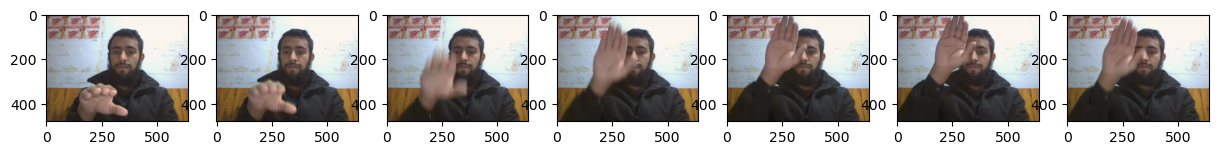

In [22]:
# View and test
def videoplot(x):
    plt.figure(1,figsize=(15,5))
    for i in range(7):
        plt.subplot(1,7,i+1)
        plt.imshow(x[i].transpose(0,2).transpose(0,1))

def view_test(model, data):
    model.eval()
    with torch.no_grad():
        for i, (x,y) in enumerate(data):
            videoplot(x[0])
            x = local_transform(x)
            x = x.flatten(start_dim=1).to(device)
            y = y.to(device)
            
            y_hat = model(x)
            _, y_hat = torch.max(y_hat,1)
            print("Prediction:", class_map[int(y_hat[0])])
            print("Label:", class_map[int(y[0])])
            break
view_test(model, test_loader)

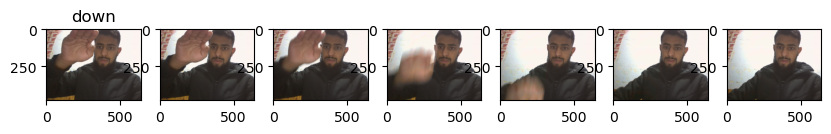

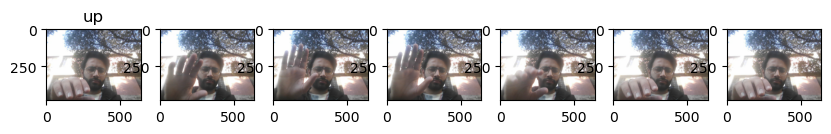

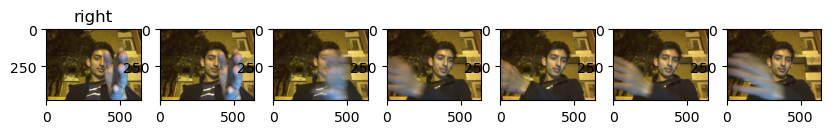

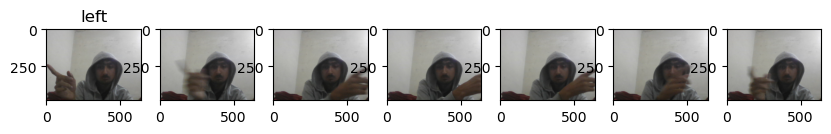

In [43]:
# View dataset
def videoplot(x,i=1,title=None):
    plt.figure(i,figsize=(10,5))
    for i in range(7):
        plt.subplot(1,7,i+1)
        plt.imshow(x[i].transpose(0,2).transpose(0,1))
    plt.subplot(1,7,1)
    plt.title(title)

def view_dataset(data):
    class_map = {0:'down', 1:'left', 2:'right', 3:'up'}
    class_done = [0 for key in class_map]
    for i, (x,y) in enumerate(data):
        if not class_done[y[0]]:
            videoplot(x[0],int(y[0]),class_map[int(y[0])])
            class_done[y[0]] = 1
        if sum(class_done) == len(class_done):
            break
view_dataset(test_loader)